# Local to global N input modelling

Tormey Reimer [](https://orcid.org/0000-0002-5983-2798)Richard S. Cottrell [](https://orcid.org/0000-0002-6499-7503)Alexandra Johne [](https://orcid.org/0000-0002-2816-7983)Sowdamini Sesha PrasadMarceau CormeryGage ClawsonScott HadleyHelen HamiltonBenjamin S. HalpernCatriona MacleodCamille WhiteJulia L. Blanchard

In [ ]:
library(magrittr)
library(dplyr)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'tidyr'

The following object is masked from 'package:magrittr':

    extract

here() starts at C:/Users/treimer/Documents/R-temp-files/local_to_global_mariculture_modelling

qs 0.27.3. Announcement: https://github.com/qsbase/qs/issues/103


Attaching package: 'arrow'

The following object is masked from 'package:magrittr':

    is_in

The following object is masked from 'package:utils':

    timestamp

Linking to GEOS 3.13.0, GDAL 3.10.1, PROJ 9.5.1; sf_use_s2() is TRUE

terra 1.8.50


Attaching package: 'terra'

The following object is masked from 'package:arrow':

    buffer

The following object is masked from 'package:patchwork':

    area

The following object is masked from 'package:ggpubr':

    rotate

The following object is masked from 'package:tidyr':

    extract

The following objects are masked from 'package:magrittr':

    extract, inset


Attaching package: 'rnaturalearthdata'

The following object is masked from 'package:rnaturalearth':

    countries110

Loading required package: future


Attaching package: 'purrr'

The following object is masked from 'package:magrittr':

    set_names

udunits database from C:/Users/treimer/AppData/Local/R/cache/R/renv/cache/v5/windows/R-4.4/x86_64-w64-mingw32/units/0.8-7/5d0b024902d5da97a2b64f002e92a869/units/share/udunits/udunits2.xml

In [ ]:
source(here("00_model_functions.R"))

# Input paths
input_farm_coords_path <- here() %>% file.path("data", "_general_data", "farm_locations")
input_farm_sst_path <- here() %>% file.path("data", "_general_data", "SST")
input_species_param_path <- here() %>% file.path("data", "atlantic_salmon", "params")
input_feed_profile_path <- here() %>% file.path("data", "_general_data", "diets")

# Output paths
output_farm_data_path <- here() %>% file.path("outputs", "farm_data")
output_species_data_path <- here() %>% file.path("outputs", "species_data")
output_sens_data_path <- here() %>% file.path("outputs", "sensitivity_data")
output_farm_growth_data_path <- here() %>% file.path("outputs", "farm_growth_data")
output_cohort_growth_data_path <- here() %>% file.path("outputs", "cohort_growth_data")
data_analysis_path <- here() %>% file.path("outputs", "data_analysis")

# Filenames
farm_coords_file <- file.path(output_farm_data_path, "farm_coords.qs")
species_params_file <- file.path(output_species_data_path, "species_params.qs")
pop_params_file <- file.path(output_species_data_path, "pop_params.qs")
feed_params_file <- file.path(output_species_data_path, "feed_params.qs")
sens_params_file <- file.path(output_species_data_path, "sens_params.qs")
sens_results_files <- file.path(output_sens_data_path) %>% str_subset("results")

species_params <- qread(species_params_file)
pop_params <- qread(pop_params_file)

# Introduction

<span class="column-margin margin-aside">This is a note create with the `aside` class.</span>

Aquaculture is now the dominant form of aquatic animal food (herein ‘seafood’) production and is expected to be the primary way we meet future seafood demand. Freshwater systems will likely continue to provide the majority of farmed seafood but marine aquaculture is also poised to expand substantially in numerous areas. Farmed marine fish and invertebrates are produced near exclusively in coastal waters, and nearly three quarters of this production is dependent on human-made feeds. Nearshore locations and feed inputs are necessary to maintain profitable and productive farming operations but coastal aquaculture generates a number of challenges. In the crowded coastal zone, aquaculture operations can conflict with other stakeholder uses such as recreation, fishing, renewable energy, transport, and tourism. And while farming marine fish typically generates a far smaller nutrient footprint than livestock farming, the overt nature of aquaculture in nearshore regions and evidence of localised nutrient impacts around fish farms remains a primary public and scientific concern. Identifying strategies that reduce ecosystem impacts from fish farm waste therefore represents an important goal for improving marine aquaculture sustainability and maintaining the sector’s social licence to operate.

Aquaculture feeds represent an important lever for reducing nutrient waste impacts around fish farms. Like all farmed animals, fish and invertebrates must digest the nutrients contained in feeds before they can be used for growth. Any nutrients left undigested are egested as solid waste, and dissolved wastes are excreted as metabolic waste products. Further, some feed inevitably remains uneaten and is lost to the surrounding ecosystem. Particulate organic matter (both feed and faeces) that settles can simplify benthic communities as the oxygen demand from its decomposition drives the production of sulphides that kill less mobile faunal, encouraging a lower diversity of opportunistic scavengers and the growth of bacterial mats (e.g., Beggiatoa spp). Thus, the chemical composition of the ingredients used in aquaculture feeds and their digestibility for the farmed species has significant implications for the nature and reactivity of the waste generate by marine aquaculture.

Firstly the overall volume of nutrient waste is dictated by the nature and intensity of production, that is the farm size, the density of farmed animals and the feed requirements and efficiency of the species grown. SecondlDeposition of waste is heavily influenced by water depth and current speed at the farming site. Once

As farmed fish and invertebrates are fed, whatever

Nutand its impact on marine ecosystems is influenced by many factors. \* Farm size \* Depth \* Current speed \* Benthic impact - sediment type/faunal assemblages/wider marine community \* High turnover environments - nitrogen enriched areas \* Feed influences all of these things

The primary source of organic waste from fed aquaculture production comes from the excretion and faeces of the farmed animals and through uneaten feed that dissolves in the water column or settles on the benthos. The nature and impact of this waste are influenced heavily by the composition of the feeds fed to farmed animals.

## P2

-   Waste from aquaculture farms and it’s impact is influenced by many things but the composition of feeds plays a central role.
-   Waste from aquaculture farms has multiple sources.
-   The primary source of organic waste comes from the faeces and excretion of the fish or invertebrates.
-   Uneaten feed produced another key source.
-   The nature and impact of this waste are influenced heavily by the composition of the feeds fed to farmed animals
-   Many marine fish are naturally carnivorous so diets used to be high in fishmeal and oil but increasing fishmeal and oil prices along with concerns over the sustainability of marine ingredients have led to a reduction in their use across multiple farmed taxa
-   In lieu of fishmeal and oil, many plant-based ingredients such as soy protein concentrate, canola oil, and wheat gluten have replaced them.
-   Changes in feed composition influences the digestibility of the nutrients held in each feed and can alter the composition of waste.
-   Of particular concern are changes (increases) to the presence of reactive nitrogen and phosphorus in coastal waters that could have an effect on eutrophication.

## P3

-   Whether or not nutrients lead to eutrophication depends on the sensitivity of the receiving environment
-   Ecosystems that are already enriched through natural processes and whose biota is well adapted to substantial fluxes in available nutrients (e.g. upwelling zones, dynamic coastal communities) may be less sensitive while oligotrophic ecosystem are likely to see considerable changes under nutrient enrichment scenarios.
-   To understand the impact of aquaculture waste under present day or future scenarios we need to quantify the volume, nature, and location of mariculture waste and determine the sensitivity of the receiving environments to that waste. Yet only recent estimates even give us the estimated location of marine farms let alone the volume of nature of the waste produced. To address this gap, we use existing maps of mariculture location with a bioenergtic model

# Methods

In [ ]:
farms_to_omit <- file.path(input_farm_coords_path, "atlantic_salmon_farms_to_omit.qs") %>% qs::qread()
farm_ts_data <- file.path(output_farm_data_path, "farm_ts_data.qs") %>% qs::qread()
farm_coords <- file.path(output_farm_data_path, "farm_coords.qs") %>% qs::qread() %>% 
    mutate(hemisphere = case_when(lat < 0 ~ "S", T ~ "N") %>% as.factor()) 

farms_geometry <- file.path(output_farm_data_path, "farm_geometry.qs") %>% qs::qread() %>% 
  rename(farm_ID = farm_id)

sorted_countries <- farm_coords %>% 
  merge(farms_geometry, by = "farm_ID") %>% 
  group_by(country) %>% 
  reframe(av_lat = mean(lat)) %>% 
  arrange(-av_lat) %>% 
  pull(country) %>% 
  unique()

## Farm temperature forcings

In [ ]:
farm_temp_means <- farm_ts_data %>% 
  group_by(farm_ID) %>% 
  reframe(mean_temp = mean(temp_c)) %>% 
  merge(farms_geometry, by = "farm_ID") %>% 
  merge(farm_coords, by = "farm_ID") %>% 
  dplyr::filter(!farm_ID %in% farms_to_omit)

overall_mean <- mean(farm_temp_means$mean_temp)
overall_sd <- sd(farm_temp_means$mean_temp)

rm(farm_ts_data)

Mean daily temperatures at the farms globally ranged from from 6$^{\circ}$ to 16.7$^{\circ}$, with an overall mean of 10.1$^{\circ}$ ($\pm$ 1.8 SD). Farms with a mean temperature of $\leq 6^\circ$C were excluded (4 farms). The total number of farms included in this analysis was therefore 2717.

In [ ]:
worldmap <- ne_countries(scale = "medium", returnclass = "sf")

p1 <- ggplot(data = worldmap, aes(geometry = geometry)) +
  geom_sf(fill = "white", color = "dimgray") +
  geom_sf(data = farm_temp_means, aes(colour = mean_temp), size = 1.5) +
  coord_sf() +
  theme_classic() 

p2 <- farm_temp_means %>% 
  ggplot(aes(y = mean_temp, x = abs(lat), colour = country)) +
  geom_point(size = 2.5) +
  scale_colour_brewer(palette = "Set1") +
  labs(x = expression("Absolute latitude ("*degree*")"), y = expression("Mean temperature ("*degree*"C)")) +
  theme_classic() +
  theme(legend.position = "top", legend.title = element_blank())

p3 <- farm_temp_means %>% 
  mutate(hemisphere = case_when(lat < 0 ~ "S", T ~ "N")) %>% 
  ggplot(aes(x = mean_temp, fill = hemisphere)) +
  geom_histogram(position = "identity", colour = "black", alpha = 0.5, binwidth = 0.5) +
  labs(x = expression("Mean temperature ("*degree*"C)"), y = "Frequency") +
  theme_classic() +
  theme(legend.position = "top", legend.title = element_blank())

(p2 + p3) / p1 + plot_layout(heights = c(1, 1.5))

## Model and approach

We adapted the methods of Baldan et al. ([2018](#ref-baldan_r_2018)) to create a bioenergetic model that simulates individual growth and farm-scale production for Atlantic salmon and the resultant nutrient waste in the form of excess labile nitrogen and phosphorus. The model simulates growth at an individual level, calculating the change in individual weight through time using:

$$
\frac{dw}{dt} = \frac{A-C}{\epsilon}
$$

Where $w=$ is wet weight (t), $t=$ time (d), $A=$ anabolic rate (J t$^{-1}$), $C=$ the catabolic rate (J t$^{-1}$), $\epsilon=$ energy density of body tissues (J t$^{-1}$). Individual models were then upscaled using monte-carlo simulations to simulate size structure in a population. Size differences were achieved through different initial starting weights and ingestion rates for different finfish species. All individuals have a fixed mortality rate to simulate stocking and harvesting.

<span class="column-margin margin-aside">Need to put the cohort concept (and harvest timing) in here.</span>

In [ ]:
fnms <- output_cohort_growth_data_path %>% 
  list.files(full.names = T) %>% 
  str_subset("biomass")

df <- fnms[1] %>% read_parquet() %>% 
  filter(feed == "reference") %>% 
  mutate(mean = set_units(mean, "g") %>% set_units("t"),
         sd = set_units(sd, "g") %>% set_units("t"))

ggplot(df, aes(x = yday, y = mean, ymin = mean-sd, ymax = mean+sd, colour = as.factor(cohort))) +
  geom_line(linewidth = 0.75) +
  geom_ribbon(linetype = "dotted", alpha = 0) +
  scale_x_continuous(breaks = seq(0, 2000, 200)) +
  labs(y = "Farm biomass", x = "Day of the year") +
  theme_classic() +
  theme(legend.position = "none", aspect.ratio = 0.75)

yrs <- max(df$yday)/365
harvests <- df %>% 
  group_by(cohort) %>% 
  reframe(mean = maxna(mean),
          sd = maxna(sd))

sum(harvests$mean)/yrs
mean(harvests$sd)/yrs

### Feeding rate

In [ ]:
df <- data.frame(water_temp = seq(-5, 26, 0.25))
df$feeding <- sapply(FUN = feeding_rate, X = df$water_temp, species_params = species_params)
df <- df %>% 
mutate(ing_pot = pop_params['meanImax'] * (pop_params['meanW']^species_params['m']) * feeding,
       food_prov = NA)
for (i in 1:nrow(df)) {
  df$food_prov[i] <- food_prov_rate(pop_params = pop_params, rel_feeding = df$feeding[i], ing_pot = df$ing_pot[i], 
                                    ing_pot_10 = pop_params['meanImax'] * (pop_params['meanW']^species_params['m']) * 0.1)
}
df$ing_pot <- df$ing_pot/maxna(df$ing_pot)
df$food_prov <- df$food_prov/maxna(df$ing_pot)

df %>% 
  ggplot(aes(x = water_temp, y = ing_pot)) +
  geom_line(linewidth = 0.75) +
  geom_line(aes(y = food_prov), linewidth = 0.75, linetype = "dotted") +
  scale_y_continuous(breaks = seq(0,1.5,0.25)) +
  scale_x_continuous(breaks = seq(-5,30,5), limits = c(-5,26)) +
  labs(x = expression("Water temperature ("*degree*"C)"), y = "Relative food ingested/provided") +
  theme_classic() +
  theme(text = element_text(colour = "black", family = "serif", size = 12))

## Production parameters

-   Salmon cohorts were always grown for 548 days
-   Salmon cohorts were put out in annually Spring, on day 274 when farm latitude \< 0 and day 121 when farm latitude \> 0.
-   Cohorts were put out every year, such that there was an annual overlap of 183 days where one cohort was nearing harvest and another was being initialised.

## Parameterisation for Atlantic salmon

In [ ]:
params <- file.path(output_species_data_path, "sens_params.qs") %>% qs::qread()

param_names <- tibble::tribble(
  ~name,        ~lab,
  "alpha",      bquote(alpha),
  "epsprot",    bquote(epsilon["P"]),
  "epslip",     bquote(epsilon["L"]),
  "epscarb",    bquote(epsilon["C"]),
  "epsO2",      bquote(epsilon["O"[2]]),
  "pk",         bquote("pk"),
  "k0",         bquote("k"[0]),
  "m",          bquote("m"),
  "n",          bquote("n"),
  "betac",      bquote(beta*"C"),
  "Tma",        bquote("T"["max"]),
  "Toa",        bquote("T"["opt"]),
  "Taa",        bquote("T"["min"]),
  "omega",      bquote(omega),
  "a",          bquote("a"),
  "k",          bquote("k"),
  "eff",        bquote("eff"),
  "meanW",      bquote(bar("W")),
  "deltaW",     bquote(Delta*"W"), 
  "meanImax",   bquote(bar("I"["max"])),
  "deltaImax",  bquote(Delta*"I"["max"]),
  "overFmean",  bquote(bar("F")),
  "overFdelta", bquote(Delta*"F"),
  "mortmyt",    bquote("mort")
)

Table <a href="#tbl-params" class="quarto-xref">Table 1</a> shows the parameter values used to model the growth of farmed Atlantic salmon.

| Parameter | Value | Units | Description | Reference |
|:--:|:--:|:--:|:---|:---|
| $\alpha$ | 0.04 | \- | Feeding catabolism coefficient | *Salvelinus alpinus*, *Oncorhynchus mykiss* (temps: 8–13$^{\circ}$C) ([Broekhuizen et al. 1994](#ref-broekhuizen_modelling_1994)) |
| $\epsilon_{P}$ | 2.36^{4} | J g protein$^{-1}$ | Energy content of protein | Baldan et al. ([2018](#ref-baldan_r_2018)) |
| $\epsilon_{L}$ | 3.62^{4} | J g lipid$^{-1}$ | Energy content of lipid | Baldan et al. ([2018](#ref-baldan_r_2018)) |
| $\epsilon_{C}$ | 1.72^{4} | J g carbohydrate$^{-1}$ | Energy content of carbohydrate | Baldan et al. ([2018](#ref-baldan_r_2018)) |
| $\epsilon_{O_2}$ | 1.34^{4} | J g O2$^{-1}$ | Energy consumed by the respiration of 1 g of oxygen | Elliott and Davison ([1975](#ref-elliott_energy_1975)) |
| pk | 0.05 | d$^{-1}$ | Temperature coefficient for the fasting catabolism | Macnaughton et al. ([2019](#ref-macnaughton_using_2019)) |
| $k_0$ | 0.003 | \- | Fasting catabolism at 0 $^{^\circ}$C | Macnaughton et al. ([2019](#ref-macnaughton_using_2019)) |
| m | 0.75 | \- | Weight exponent for anabolism | Experimentally-derived alue over a range of *Oncorhynchus*, *Perca* and *Salmo* species (temps: 8–13$^{\circ}$C) ([Broekhuizen et al. 1994](#ref-broekhuizen_modelling_1994)) |
| n | 1 | \- | Weight exponent for catabolism | Baldan et al. ([2018](#ref-baldan_r_2018)) |
| $\beta C$ | 0.3234 | \- | Shape coefficient for the feeding function | Fish size range: 2.25 $\pm$ 0.49 – 11.5 $\pm$ 5.29 g, temperature ranges: 5–24$\^{\circ}$C. Coefficent for mean daily energy intake of the moderately fast growing group, 0.4398 (mean fast group), 0.2214 (mean slow group) ([B. Jonsson et al. 2001](#ref-jonsson_thermal_2001)) |
| $T_{max}$ | 26 | $^{^\circ}$C | Maximum lethal temperature | Juvenile *Oncorhynchus tshawytscha* (19.8 $\pm$ 0.02 g, acclimation temp: 15$^{^\circ}$C, 19${\circ}$C) ([Poletto et al. 2017](#ref-poletto_unusual_2017)) |
| $T_{opt}$ | 16 | $^{^\circ}$C | Optimal temperature | Fish size range: 2.25 $\pm$ 0.49 – 11.5 $\pm$ 5.29 g, temperature ranges: 5–24$^{^\circ}$C ([B. Jonsson et al. 2001](#ref-jonsson_thermal_2001)). Alt value: 14°C ([Handeland, Imsland, and Stefansson 2008](#ref-handeland_effect_2008)), *Salmo salar* initial size: 77.0 $\pm$ 14.6 g, temps: 6, 10, 14, 18${\circ}$C |
| $T_{min}$ | 2 | $^{^\circ}$C | Lowest feeding temperature | Fish essentially stop feeding when below 2$^{\circ}$C ([Vadboncoeur et al. 2023](#ref-vadboncoeur_lowering_2023)) |
| $\omega$ | 0.6542 | g O2 / g | Oxygen consumption:weight loss ratio | Calibrated value from Baldan et al. ([2018](#ref-baldan_r_2018)) |
| a | 2669 | J g tissue$^{-1}$ | Energy content of fish tissue | Alt value: 17.02350 (nls model fitted to female Atlantic salmon data extracted and transformed from N. Jonsson and Jonsson ([2003](#ref-jonsson_energy_2003); [Van Tien et al. 2016](#ref-van_tien_development_2016)) |
| k | 0.1715 | \- | Weight exponent for energy content | Alt value: 1.65175 (nls model fitted to female Atlantic salmon data extracted and transformed from N. Jonsson and Jonsson ([2003](#ref-jonsson_energy_2003); [Van Tien et al. 2016](#ref-van_tien_development_2016)) |
| eff | 0.97 | \- | Food ingestion efficiency | Range: 95-97% ingestion efficiency ([Uglem et al. 2020](#ref-uglem_does_2020)) |
| $\overline{W}$ | 125 | g | Dry weight mean | Range of 100-150 given so used a mean of 125 and sd of 10 which over 1000 draws from a normal distribution delivers a minimum and maximum close to these numbers ([Dempsey et al. 2023](#ref-dempsey_estimating_2023)) |
| $\Delta{W}$ | 10 | g | Dry weight standard deviation | Range of 100-150 given so used a mean of 125 and sd of 10 which over 1000 draws from a normal distribution delivers a minimum and maximum close to these numbers ([Dempsey et al. 2023](#ref-dempsey_estimating_2023)) |
| $\overline{I_{max}}$ | 0.035 | g g$^{-1}$ fish day$^{-1}$ | Ingestion rate mean | [FAO](https://www.fao.org/fileadmin/user_upload/affris/docs/tabl10.pdf) |
| $\Delta{I_{max}}$ | 0.005 | g g$^{-1}$ fish day$^{-1}$ | Ingestion rate standard deviation | [FAO](https://www.fao.org/fileadmin/user_upload/affris/docs/tabl10.pdf) |
| $\overline{F}$ | 0.015 | g g$^{-1}$ fish\$ | Overfeeding rate mean |  |
| $\Delta{F}$ | 0.0045 | g g$^{-1}$ fish\$ | Overfeeding rate standard deviation |  |
| mort | 5.99798^{-4} | d$^{-1}$ | Natural mortality rate | Tvete, Aldrin, and Jensen ([2023](#ref-tvete_towards_2023)) |

Table 1: Model growth parameters for Atlantic salmon

### Testing parameter sensitivity

Parameter sensitivity was tested by varying each parameter in <a href="#tbl-params" class="quarto-xref">Table 1</a> by $\pm 10$% and calculating sensitivity as:

$$
S_p = \frac{(P_{1.1} - P_{0.9})}{0.2 \times P_1}
$$

where $S$ is the sensitivity of the measured variable to changes in parameter $p$, and $P_{1.1}$, $P_{0.9}$, and $P_{1}$ are the value of the measured variable when the model is run with parameter $p$ at 110%, 90%, and 100% of its value respectively.

-   All parameters in Table <a href="#tbl-params" class="quarto-xref">Table 1</a> were tested across all farms (all temperatures)
-   Used a population of 100 in each farm

In [ ]:
sens_weight <- output_sens_data_path %>% 
  list.files(full.names = T) %>% 
  str_subset("results") %>% 
  str_subset("weight") %>% 
  qs::qread()

sens_excr <- output_sens_data_path %>% 
  list.files(full.names = T) %>% 
  str_subset("results") %>% 
  str_subset("total_excr") %>% 
  qs::qread() 

sens_data <- rbind(sens_weight, sens_excr) %>% 
  mutate(adj_param = factor(adj_param, levels = param_names$name))

Looking at <a href="#fig-param-sens-weight" class="quarto-xref">Figure 2</a>:

-   The most sensitive parameter by far is $m$ (the weight exponent for anabolism), followed closely by $n$ the (weight exponent for catabolism)
-   These two are also relatively uncertain, as $m$ was taken from *Salmo trutta* measurements in a fairly old paper ([Broekhuizen et al. 1994](#ref-broekhuizen_modelling_1994)) and $n$ was taken from Baldan et al. ([2018](#ref-baldan_r_2018)) which did not specifically look at Atlantic salmon. There must be more up-to-date measurements for Atlantic salmon in particular.

In [ ]:
sens_data %>% 
  ggplot(aes(x = adj_param, y = mean_sens, ymin = mean_sens - sd_sens, ymax = mean_sens + sd_sens, fill = measure)) +
  geom_col(position = position_dodge(), width = 0.95, colour = "black", alpha = 0.75) +
  # geom_errorbar(position = position_dodge(width = 0.95), width = 0.3) +
  geom_hline(aes(yintercept = 0), linetype = "dashed") +
  scale_y_continuous(breaks = seq(-30,30,5), limits = c(-10,30)) +
  scale_x_discrete(limits = rev(param_names$name), labels = rev(param_names$lab)) +
  scale_fill_manual(values = c(weight = "salmon", total_excr = "steelblue")) +
  # scale_fill_manual(values = c("weight" = "salmon", "uneat" = "steelblue", "excr" = "darkgreen")) +
  labs(x = "Adjusted parameter", y = "Sensitivity") +
  theme_classic() + 
  theme(legend.position = "none", 
        strip.text = element_blank(), 
        aspect.ratio = 0.8,
        text = element_text(size = 12),
        axis.title.y = element_blank()) +
  coord_flip()

## Modelled experimental feeds

In [ ]:
feed_pal <- c("past" = brewer.pal(9, "Set1")[1], "reference" = brewer.pal(9, "Set1")[2], "future" = brewer.pal(9, "Set1")[3])
feed_params <- file.path(output_species_data_path, "feed_params.qs") %>% qs::qread()

df <- feed_params[["reference"]]
contribP_1 <- df[["Proteins"]]$proportion*df[["Proteins"]]$macro
tP_1 <- sum(contribP_1)
digestP_1 <- sum(df[["Proteins"]]$digest * contribP_1)/tP_1

contribL_1 <- df[["Lipids"]]$proportion*df[["Lipids"]]$macro
tL_1 <- sum(contribL_1)
digestL <- sum(df[["Lipids"]]$digest * contribL_1)/tL_1

contribC_1 <- df[["Carbohydrates"]]$proportion*df[["Carbohydrates"]]$macro
tC_1 <- sum(contribC_1)
digestC_1 <- sum(df[["Carbohydrates"]]$digest * contribC_1)/tC_1

df <- feed_params[["past"]]
contribP_2 <- df[["Proteins"]]$proportion*df[["Proteins"]]$macro
tP_2 <- sum(contribP_2)
digestP_2 <- sum(df[["Proteins"]]$digest * contribP_2)/tP_2

contribL_2 <- df[["Lipids"]]$proportion*df[["Lipids"]]$macro
tL_2 <- sum(contribL_2)
digestL <- sum(df[["Lipids"]]$digest * contribL_2)/tL_2

contribC_2 <- df[["Carbohydrates"]]$proportion*df[["Carbohydrates"]]$macro
tC_2 <- sum(contribC_2)
digestC_2 <- sum(df[["Carbohydrates"]]$digest * contribC_2)/tC_2

df <- feed_params[["future"]]
contribP_3 <- df[["Proteins"]]$proportion*df[["Proteins"]]$macro
tP_3 <- sum(contribP_3)
digestP_3 <- sum(df[["Proteins"]]$digest * contribP_3)/tP_3

contribL_3 <- df[["Lipids"]]$proportion*df[["Lipids"]]$macro
tL_3 <- sum(contribL_3)
digestL <- sum(df[["Lipids"]]$digest * contribL_3)/tL_3

contribC_3 <- df[["Carbohydrates"]]$proportion*df[["Carbohydrates"]]$macro
tC_3 <- sum(contribC_3)
digestC_3 <- sum(df[["Carbohydrates"]]$digest * contribC_3)/tC_3

-   Feed came from ([Cottrell et al., n.d.](#ref-cottrell_origins_nodate), [2020](#ref-cottrell_global_2020))
-   The reference feed is 37.8% protein, 36.5% lipid, 20.4% carbohydrate.
-   The past feed is 49.8% protein, 27.1% lipid, 16.6% carbohydrate.
-   The future feed is 47.7% protein, 32.9% lipid, 13.9% carbohydrate.
-   Within the reference feed, protein is overall 89.2% digestible, lipid is overall 96% digestible, and carbohydrate is overall 69.6% digestible.
-   Within the reference feed, protein is overall 90.5% digestible, lipid is overall 96% digestible, and carbohydrate is overall 79.7% digestible.
-   Within the reference feed, protein is overall 86.2% digestible, lipid is overall 96% digestible, and carbohydrate is overall 69.3% digestible.

## Population and biomass estimates

New method is to take the average predicted individual harvest size for each farm, then working backwards with the standard mortality rate to generate a population for each farm that will produce the correct tonnage for each farm. <a href="#fig-harvest-size" class="quarto-xref">Figure 3</a> shows the average individual harvest size at each farm as predicted by the fish-growth model, which was used to create the population inputs for the farm-level growth curves.

In [ ]:
file.path(output_farm_data_path, "farm_harvest_size.qs") %>% 
  qread() %>% 
  mutate(weight = weight %>% set_units("g") %>% set_units("kg")) %>% 
  select(c(farm_ID, weight)) %>% 
  ggplot(aes(x = weight)) +
  geom_histogram(binwidth = 0.25, colour = "black", fill = "salmon", alpha = 0.75) +
  scale_y_continuous(limits = c(0,500)) +
  labs(y = "Frequency", x = "Harvest weight") +
  theme_classic() +
  theme(
    legend.position = "none", 
    aspect.ratio = 0.75
  )

This means that the population estimates aren’t actual fish numbers, they’re just a method that allows each farm location to approximate of the correct tonnage produced while to allowing comparisons between the different feeds.

## Biomass produced

## Species vulnerability layers

# Results

-   Main point is the difference between feeds (kg/t salmon).
-   Also interesting to see if difference between feeds varies geographically (correlates with mean/median/max temperature?)

In [ ]:
farmrun_files <- file.path(output_cohort_growth_data_path) %>% 
  list.files(full.names = T)

qs::qread(farmrun_files[1]) %>% names()

 [1] "weight_stat"      "dw_stat"          "water_temp_stat"  "T_response_stat" 
 [5] "P_excr_stat"      "L_excr_stat"      "C_excr_stat"      "P_uneat_stat"    
 [9] "L_uneat_stat"     "C_uneat_stat"     "food_prov_stat"   "food_enc_stat"   
[13] "rel_feeding_stat" "ing_pot_stat"     "ing_act_stat"     "E_assim_stat"    
[17] "E_somat_stat"     "anab_stat"        "catab_stat"       "O2_stat"         
[21] "NH4_stat"         "total_excr_stat"  "total_uneat_stat" "metab_stat"      
[25] "biomass_stat"    

## Uneaten feed

In [ ]:
uneaten_total <- farmrun_files %>% 
  purrr::map(function(f) {qs::qread(f)[["total_uneat_stat"]]}) %>% 
  bind_rows() %>% 
  merge(biomass, by = c("farm_ID", "feed", "t")) %>% 
  rename(uneat_mean = mean.x, biomass_mean = mean.y,
         uneat_sd = sd.x, biomass_sd = sd.y) %>% 
  mutate(uneat_sd = uneat_sd/uneat_mean,
         biomass_sd = biomass_sd/biomass_mean,
         uneat_biom_mean = uneat_mean/biomass_mean,
         uneat_biom_sd = sqrt(uneat_sd^2+biomass_sd^2)*uneat_biom_mean)

uneaten_total_stats <- uneaten_total %>% 
  group_by(feed, farm_ID) %>% 
  reframe(total = sum(uneat_biom_mean)) %>% 
  group_by(feed) %>% 
  reframe(min = minna(total),
          max = maxna(total),
          mean = meanna(total)) %>% 
  mutate(min = min %>% set_units("g gfish-1") %>% set_units("g kgfish-1"),
         max = max %>% set_units("g gfish-1") %>% set_units("g kgfish-1"),
         mean = mean %>% set_units("g gfish-1") %>% set_units("g kgfish-1")) %>% 
  mutate(min = round(min,2),
         max = round(max,2),
         mean = round(mean,2))

-   Total reference uneaten feed across a cohort (548 days) ranged from 48.46 to 48.46 g kg$^{-1}$, with a mean of 61.71.
-   There was very little difference between the past and future feeds and the reference feed. Uneaten past feed ranged from 48.72 to 48.72 g kg$^{-1}$ (mean of 62.17) while uneaten future feed ranged from 48.73 to 48.73 g kg$^{-1}$ (mean of 62.05).
-   <a href="#fig-total-uneaten-perday" class="quarto-xref">Figure 4</a> shows the range of total uneaten feed per day across countries.

In [ ]:
uneaten_total %>% 
  merge(farms_geometry, by = "farm_ID") %>% 
  mutate(uneat_biom_mean = uneat_biom_mean %>% set_units("g gfish-1 d-1") %>% set_units("g kgfish-1 d-1"),
         country = factor(country, levels = sorted_countries)) %>% 
  ggplot(aes(x = country, y = uneat_biom_mean, fill = feed)) +
  geom_boxplot() +
  theme_classic() +
  scale_fill_manual(values = feed_pal) +
  labs(y = "Uneaten feed", x = "Country")

In [ ]:
uneaten_P <- farmrun_files %>% purrr::map(function(f) {qs::qread(f)[["P_uneat_stat"]]}) %>% bind_rows()
uneaten_L <- farmrun_files %>% purrr::map(function(f) {qs::qread(f)[["L_uneat_stat"]]}) %>% bind_rows()
uneaten_C <- farmrun_files %>% purrr::map(function(f) {qs::qread(f)[["C_uneat_stat"]]}) %>% bind_rows()

uneaten_all <- uneaten_total %>% 
  select(-contains("biom")) %>% 
  merge(uneaten_P, by = c("farm_ID", "feed", "t")) %>% 
  merge(uneaten_L, by = c("farm_ID", "feed", "t")) %>% 
  merge(uneaten_C, by = c("farm_ID", "feed", "t")) %>% 
  select(-c(contains("sd")))

-   The composition of the uneaten feed is (obviously) the same as the total feed composition (<a href="#sec-feeds" class="quarto-xref">Section 2.5</a>).

## Excreted faeces

In [ ]:
# The following reads in all the total excretion data and converts the mean and sd values into values/biomass
excreted_total <- farmrun_files %>% 
  purrr::map(function(f) {qs::qread(f)[["total_excr_stat"]]}) %>% 
  bind_rows() %>% 
  merge(biomass, by = c("farm_ID", "feed", "t")) %>% 
  rename(excr_mean = mean.x, biomass_mean = mean.y,
         excr_sd = sd.x, biomass_sd = sd.y) %>% 
  mutate(excr_sd = excr_sd/excr_mean,
         biomass_sd = biomass_sd/biomass_mean,
         excr_biom_mean = excr_mean/biomass_mean,
         excr_biom_sd = sqrt(excr_sd^2+biomass_sd^2)*excr_biom_mean)

excreted_total_stats <- excreted_total %>% 
  group_by(feed, farm_ID) %>% 
  reframe(total = sum(excr_biom_mean)) %>% 
  group_by(feed) %>% 
  reframe(min = minna(total),
          max = maxna(total),
          mean = meanna(total)) %>% 
  mutate(min = min %>% set_units("g gfish-1") %>% set_units("g kgfish-1"),
         max = max %>% set_units("g gfish-1") %>% set_units("g kgfish-1"),
         mean = mean %>% set_units("g gfish-1") %>% set_units("g kgfish-1")) %>% 
  mutate(min = round(min,2),
         max = round(max,2),
         mean = round(mean,2))

-   Total reference excreted faeces across a cohort (548 days) ranged from 194.24 to 295.9 g kg$^{-1}$, with a mean of 247.38.
-   There was very little difference between the past and future feeds and the reference feed. Uneaten past feed ranged from 154.33 to 236.05 g kg$^{-1}$ (mean of 196.94 g kg$^{-1}$) while uneaten future feed ranged from 202.55 to 308.61 g kg$^{-1}$ (mean of 257.91 g kg$^{-1}$).
-   <a href="#fig-total-excreted-perday" class="quarto-xref">Figure 5</a> shows the range of total excreted faeces per day across countries.

In [ ]:
excreted_total %>% 
  merge(farms_geometry, by = "farm_ID") %>% 
  mutate(excr_biom_mean = excr_biom_mean %>% set_units("g gfish-1 d-1") %>% set_units("g kgfish-1 d-1"),
         country = factor(country, levels = sorted_countries)) %>% 
  ggplot(aes(x = country, y = excr_biom_mean, fill = feed)) +
  geom_boxplot() +
  theme_classic() +
  scale_fill_manual(values = feed_pal) +
  labs(y = "Excreted faeces", x = "Country")

### Total amount

There was very little variation in the percentage difference (from reference) excreted with increasing overall excretion (<a href="#fig-total-excr-diff_perc" class="quarto-xref">Figure 6</a>), or through time (<a href="#fig-total-excr-diff_perc_2" class="quarto-xref">Figure 7</a>). The difference in total excretion for the past feed ranged from -26, -26.1–23.9, -23.9% across all farms globally, and for the future feed ranged from 1.3, 1.3-4.1, 3.7%.

However, the actual difference in excreted faeces varied by feed, time in the production cycle, and location of the farm <a href="#fig-total-excr-act_diff" class="quarto-xref">Figure 8</a>.

In [ ]:
df <- excr_total %>% 
  select(-c(sd, sd_pc)) %>% 
  pivot_wider(names_from = "feed", values_from = "mean") %>% 
  mutate(past = past-reference,
         future = future-reference) %>% 
  pivot_longer(names_to = "feed", values_to = "diff", cols = c(past, future), names_transform = list(feed = as.factor)) %>% 
  mutate(reference = set_units(reference, "g kgfish-1 d-1"),
         diff = set_units(diff, "kg tfish-1 d-1")) 

summ <- df %>%
  group_by(hemisphere, feed) %>% 
  reframe(mean = meanna(diff) %>% round(3),
          min = meanna(diff) %>% round(3),
          max = maxna(diff) %>% round(3))

df %>% 
  group_by(hemisphere, feed, prod_day) %>% 
  reframe(mean_diff = meanna(diff),
          sd_diff = sdna(diff) %>% set_units("kg tfish-1 d-1")) %>% 
  ggplot(aes(x = prod_day, y = mean_diff, ymin = mean_diff-sd_diff, ymax = mean_diff+sd_diff, colour = hemisphere, fill = hemisphere)) +
  geom_line(linewidth = 0.75) +
  geom_ribbon(alpha = 0.25) +
  facet_wrap(~feed) +
  theme_classic()

### Excreted composition

In [ ]:
excreted_P <- farmrun_files %>% purrr::map(function(f) {qs::qread(f)[["P_excr_stat"]]}) %>% bind_rows()
excreted_L <- farmrun_files %>% purrr::map(function(f) {qs::qread(f)[["L_excr_stat"]]}) %>% bind_rows()
excreted_C <- farmrun_files %>% purrr::map(function(f) {qs::qread(f)[["C_excr_stat"]]}) %>% bind_rows()

excreted_all <- excreted_total %>% 
  select(-contains("biom")) %>% 
  merge(excreted_P, by = c("farm_ID", "feed", "t")) %>% 
  merge(excreted_L, by = c("farm_ID", "feed", "t")) %>% 
  merge(excreted_C, by = c("farm_ID", "feed", "t")) %>% 
  select(-c(contains("sd"))) %>% 
  rename(protein = mean.x, lipids = mean.y, carbohydrates = mean) %>% 
  mutate(protein = protein/excr_mean %>% set_units("d-1"),
         lipids = lipids/excr_mean %>% set_units("d-1"),
         carbohydrates = carbohydrates/excr_mean %>% set_units("d-1")) %>% 
  select(-excr_mean)

Unlike the uneaten feed, the composition of excreted faeces differs from that of the incoming feed.

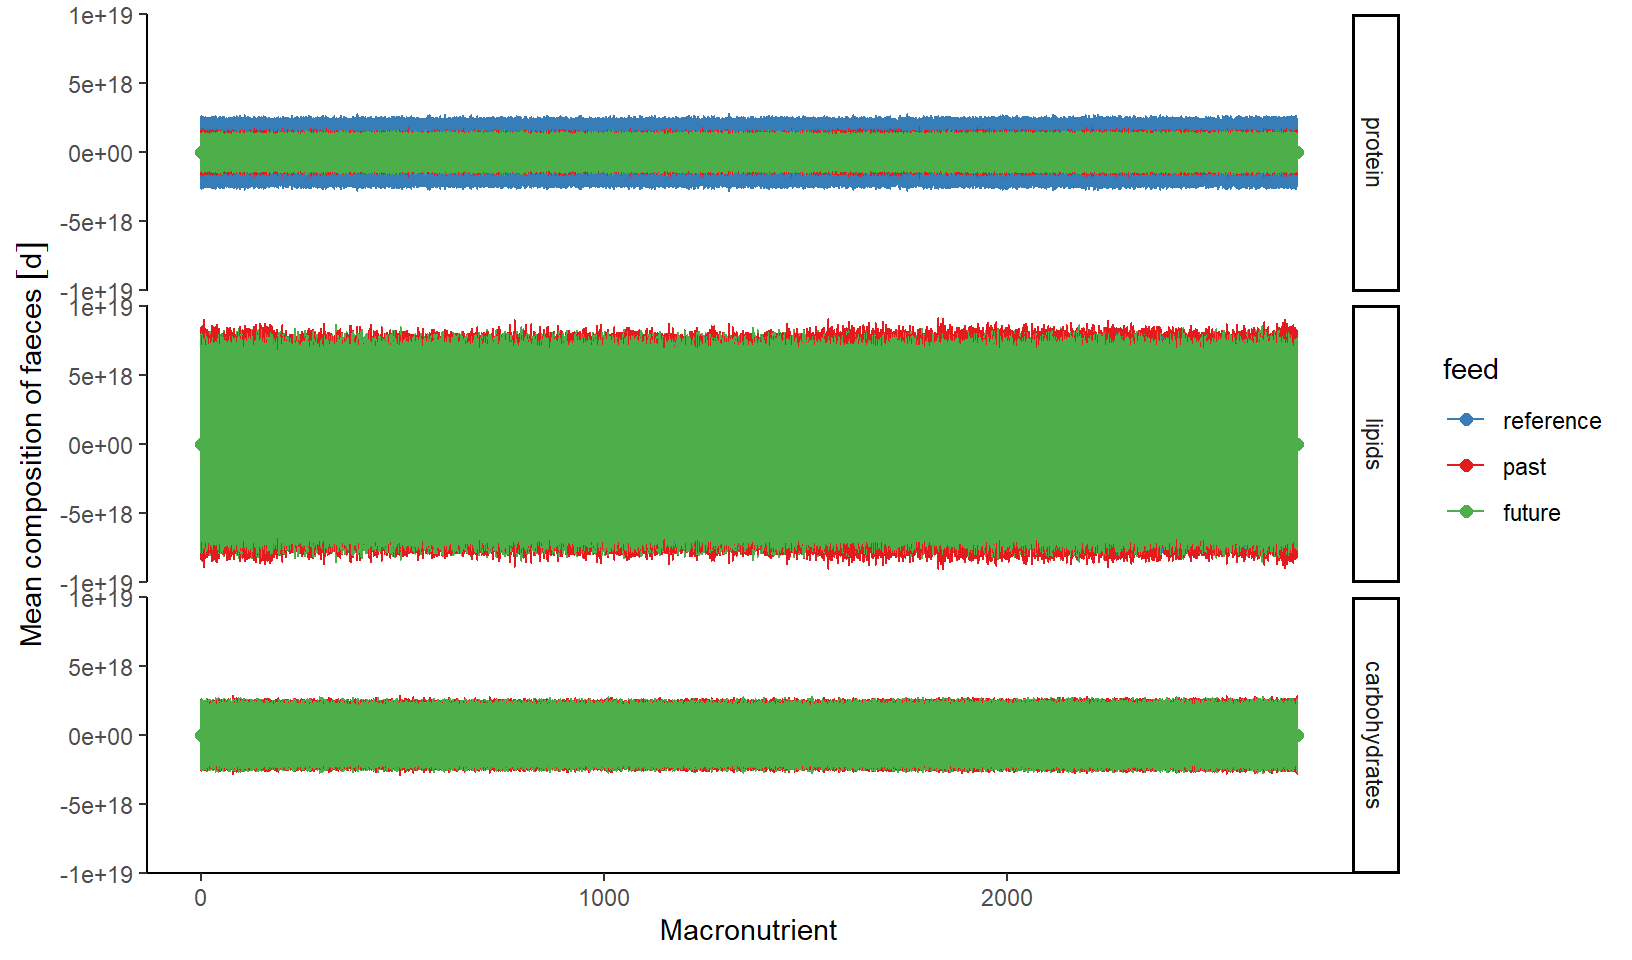

In [ ]:
excreted_all %>% 
  pivot_longer(names_to = "macro", values_to = "perc", cols = c("protein", "lipids", "carbohydrates")) %>% 
  mutate(macro = factor(macro, levels = c("protein", "lipids", "carbohydrates"))) %>% 
  group_by(farm_ID, feed, macro) %>% 
  reframe(sd = sd(perc) %>% set_units("d-1"),
          mean = mean(perc)) %>% 
  ggplot(aes(x = farm_ID, colour = feed, fill = feed, y = 100*mean, ymin = 100*(mean-sd), ymax = 100*(mean+sd))) +
  geom_point(size = 2) +
  geom_errorbar(width = 0.5) +
  scale_color_manual(values = feed_pal) +
  scale_fill_manual(values = feed_pal) +
  facet_grid(rows = vars(macro)) +
  theme_classic() +
  labs(x = "Macronutrient", y = "Mean composition of faeces")

## Total nutrients (amount & source)

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.

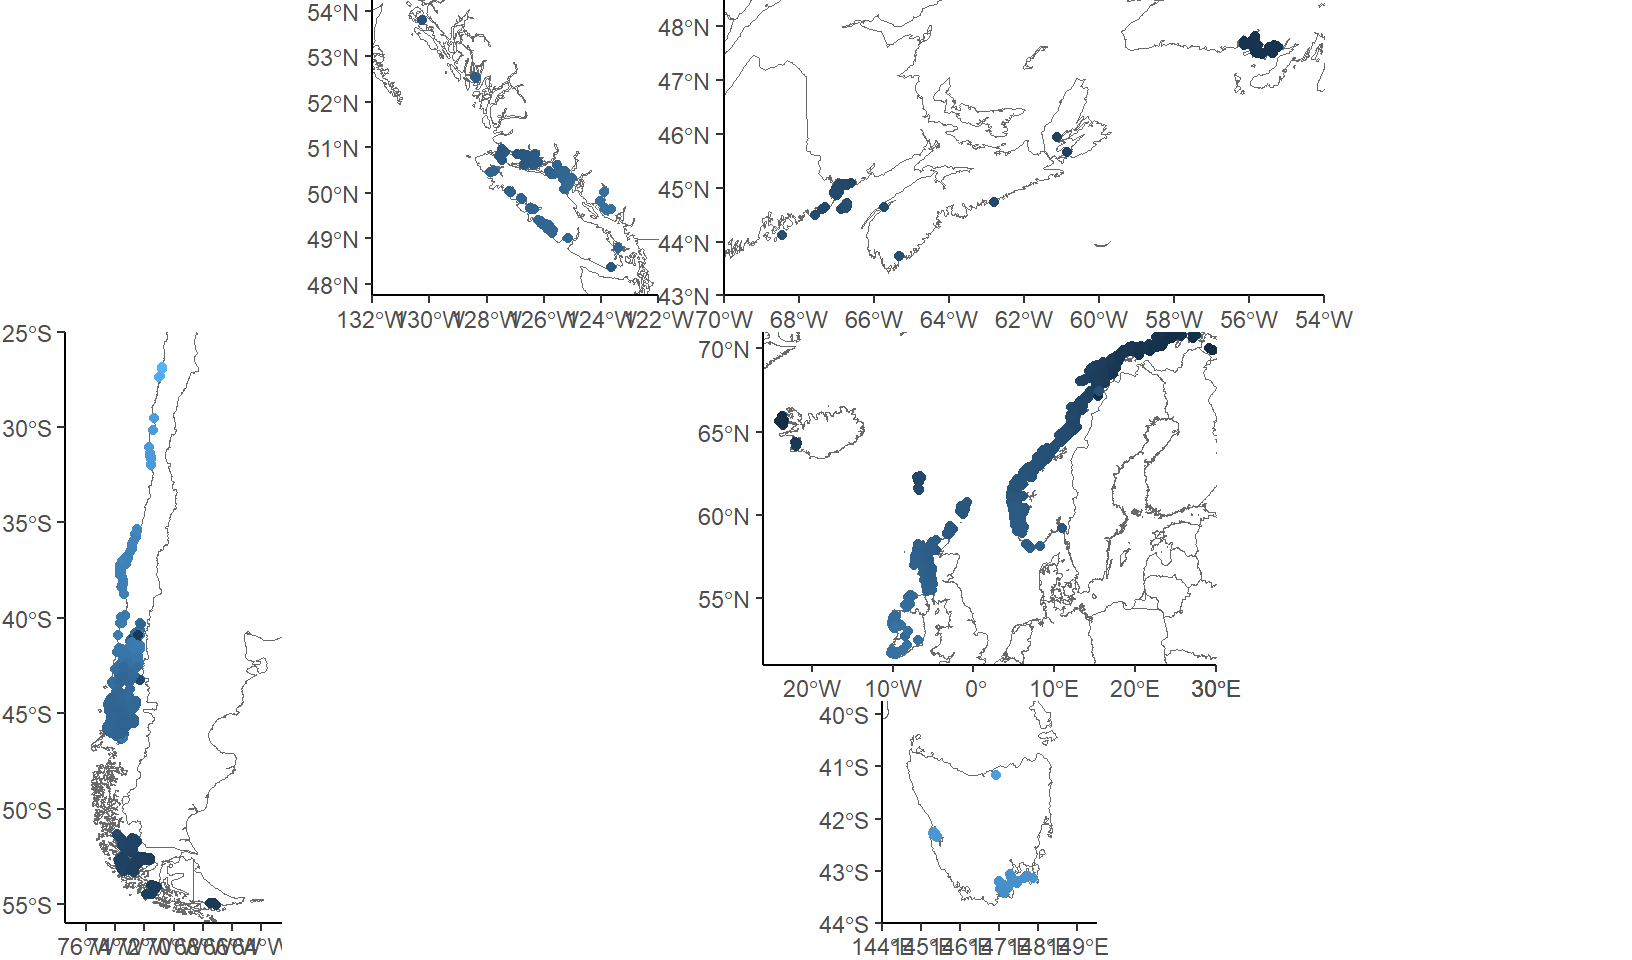

In [ ]:
worldmap <- ne_countries(scale = "large", returnclass = "sf")

AUS_bounds <- c(144, 149.5, -39.75, -44)
CAN1_bounds <- c(-132, -122, 47.75, 54.25)
CAN2_bounds <- c(-70, -54, 43, 48.5)
CHI_bounds <- c(-77.5, -62.5, -56, -25)
EUR_bounds <- c(-26, 30, 51, 71)

p_ALL <- ggplot(data = worldmap, aes(geometry = geometry)) +
  geom_sf(fill = "white", color = "dimgray") +
  geom_sf(data = farm_temp_means, aes(colour = mean_temp), size = 1.5) +
  coord_sf() +
  theme_classic()

no_margins <- function() {
  theme(legend.position = "none", 
        plot.margin = margin(),
        axis.title = element_blank())
}

p_Aus <- p_ALL + coord_sf(xlim = AUS_bounds[1:2], ylim = AUS_bounds[3:4], expand = FALSE) + no_margins()

# Statistical analysis & code availability

All analysis was conducted in R version 4.4.2 “Pile of Leaves” ([R Core Team 2019](#ref-R_base)). Major packages used include terra ([Hijmans 2024](#ref-terra)), targets ([Landau 2021](#ref-targets)), future ([Bengtsson 2021](#ref-future)), furrr ([Vaughan and Dancho 2022](#ref-furrr)), and the tidyverse ([Wickham et al. 2019](#ref-tidyverse)). For a full list of R packages used see the lockfile on [Github](https://www.github.com). This manuscript was written in Quarto ([Allaire et al. 2024](#ref-quarto)) using TinyTex ([Xie 2017](#ref-tinytex)) and the acronyms extension ([Chaput 2024](#ref-acronyms)).

# References

Allaire, J. J., Charles Teague, Carlos Scheidegger, Yihui Xie, and Christophe Dervieux. 2024. ‘Quarto’. <https://doi.org/10.5281/zenodo.5960048>.

Baldan, Damiano, Erika M. D. Porporato, Roberto Pastres, and Daniele Brigolin. 2018. ‘An R Package for Simulating Growth and Organic Wastage in Aquaculture Farms in Response to Environmental Conditions and Husbandry Practices’. *PLOS ONE* 13 (5): e0195732. https://doi.org/<https://doi.org/10.1371/journal.pone.0195732>.

Bengtsson, Henrik. 2021. ‘A Unifying Framework for Parallel and Distributed Processing in r Using Futures’. *The R Journal* 13 (2): 208–27. <https://doi.org/10.32614/RJ-2021-048>.

Broekhuizen, Niall., William. S. C. Gurney, A. Jones, and A. D. Bryant. 1994. ‘Modelling Compensatory Growth’. *Functional Ecology* 8 (6): 770–82. https://doi.org/<https://doi.org/10.2307/2390237>.

Chaput, Remy. 2024. ‘<span class="nocase">acronyms</span>’. <https://github.com/rchaput/acronyms>.

Cottrell, Richard S., Julia L. Blanchard, Benjamin S. Halpern, Marc Metian, and Halley E. Froehlich. 2020. ‘Global Adoption of Novel Aquaculture Feeds Could Substantially Reduce Forage Fish Demand by 2030’. *Nature Food* 1 (5): 301–8. <https://doi.org/10.1038/s43016-020-0078-x>.

Cottrell, Richard S., Benjamin S. Halpern, Marceau Cormery, Helen A. Hamilton, Gage Clawson, Beth Penrose, Louise Adams, et al. n.d. ‘The Origins of Ingredients Matter More Than Ingredient Types for the Environmental Footprint of Aquaculture Feeds’.

Dempsey, Danielle P., Gregor K. Reid, Leah Lewis-McCrea, Toby Balch, Roland Cusack, André Dumas, and Jack Rensel. 2023. ‘Estimating Stocking Weights for Atlantic Salmon to Grow to Market Size at Novel Aquaculture Sites with Extreme Temperatures’. *Frontiers in Marine Science* 10 (May). https://doi.org/[https://doi.org/ 10.3389/fmars.2023.1094247](https://doi.org/ 10.3389/fmars.2023.1094247).

Elliott, J. M., and W. Davison. 1975. ‘Energy Equivalents of Oxygen Consumption in Animal Energetics’. *Oecologia* 19 (3): 195–201. https://doi.org/<https://doi.org/10.1007/BF00345305>.

Handeland, Sigurd O., Albert K. Imsland, and Sigurd O. Stefansson. 2008. ‘The Effect of Temperature and Fish Size on Growth, Feed Intake, Food Conversion Efficiency and Stomach Evacuation Rate of Atlantic Salmon Post-Smolts’. *Aquaculture* 283 (1): 36–42. https://doi.org/[https://doi.org/ 10.1016/j.aquaculture.2008.06.042](https://doi.org/ 10.1016/j.aquaculture.2008.06.042).

Hijmans, Robert J. 2024. *Terra: Spatial Data Analysis*. <https://CRAN.R-project.org/package=terra>.

Jonsson, Bror, Torbjørn Forseth, Arne. J. Jensen, and Tor. F. Næsje. 2001. ‘Thermal Performance of Juvenile Atlantic Salmon, *Salmo Salar* L.’ *Functional Ecology* 15 (6): 701–11. https://doi.org/<https://doi.org/10.1046/j.0269-8463.2001.00572.x>.

Jonsson, Nina, and Bror Jonsson. 2003. ‘Energy Allocation Among Developmental Stages, Age Groups, and Types of Atlantic Salmon (*Salmo Salar*) Spawners’. *Canadian Journal of Fisheries and Aquatic Sciences* 60 (5): 506–16. https://doi.org/[https://doi.org/ 10.1139/f03-042](https://doi.org/ 10.1139/f03-042).

Landau, William Michael. 2021. ‘The Targets r Package: A Dynamic Make-Like Function-Oriented Pipeline Toolkit for Reproducibility and High-Performance Computing’. *Journal of Open Source Software* 6 (57): 2959. <https://doi.org/10.21105/joss.02959>.

Macnaughton, Camille J., David Deslauriers, Erinn L. Ipsen, Emily Corey, and Eva C. Enders. 2019. ‘Using Meta-Analysis to Derive a Respiration Model for Atlantic Salmon (*Salmo Salar*) to Assess Bioenergetics Requirements of Juveniles in Two Canadian Rivers’. *Canadian Journal of Fisheries and Aquatic Sciences* 76 (12): 2225–34. https://doi.org/[https://doi.org/ 10.1139/cjfas-2018-0436](https://doi.org/ 10.1139/cjfas-2018-0436).

Poletto, Jamilynn B., Dennis E. Cocherell, Sarah E. Baird, Trinh X. Nguyen, Valentina Cabrera-Stagno, Anthony P. Farrell, and Nann A. Fangue. 2017. ‘Unusual Aerobic Performance at High Temperatures in Juvenile Chinook Salmon, *Oncorhynchus Tshawytscha*’. *Conservation Physiology* 5 (1). https://doi.org/[https://doi.org/ 10.1093/conphys/cow067](https://doi.org/ 10.1093/conphys/cow067).

R Core Team. 2019. *R: A Language and Environment for Statistical Computing*. Vienna, Austria: R Foundation for Statistical Computing. <https://www.R-project.org>.

Tvete, Ingunn Fride, Magne Aldrin, and Britt Bang Jensen. 2023. ‘Towards Better Survival: Modeling Drivers for Daily Mortality in Norwegian Atlantic Salmon Farming’. *Preventive Veterinary Medicine* 210 (January): 105798. https://doi.org/[https://doi.org/ 10.1016/j.prevetmed.2022.105798](https://doi.org/ 10.1016/j.prevetmed.2022.105798).

Uglem, Ingebrigt, Kilian Toledo-Guedes, Pablo Sanchez-Jerez, Eva M. Ulvan, Tor Evensen, and Bjørn S. Sæther. 2020. ‘Does Waste Feed from Salmon Farming Affect the Quality of Saithe (*Pollachius Virens* L.) Attracted to Fish Farms?’ *Aquaculture Research* 51 (4): 1720–30. https://doi.org/[https://doi.org/ 10.1111/are.14519](https://doi.org/ 10.1111/are.14519).

Vadboncoeur, Émile, Charlotte Nelson, Jennifer R. Hall, Kathy A. Clow, Rebeccah M. Sandrelli, Colin J. Brauner, Andrew K. Swanson, and A. Kurt Gamperl. 2023. ‘Lowering Temperature to 1 °C Results in Physiological Changes, Stress and Mortality in Cultured Atlantic Salmon (*Salmo Salar*)’. *Aquaculture* 568 (April): 739313. https://doi.org/[https://doi.org/ 10.1016/j.aquaculture.2023.739313](https://doi.org/ 10.1016/j.aquaculture.2023.739313).

Van Tien, Nguyen, Dam T. M. Chinh, Tran T. M. Huong, Truong H. Phuong, Simon Irvin, and Brett Glencross. 2016. ‘Development of a Nutritional Model to Define the Energy and Protein Requirements of Cobia, *Rachycentron Canadum*’. *Aquaculture* 463 (October): 193–200. https://doi.org/[https://doi.org/ 10.1016/j.aquaculture.2016.05.037](https://doi.org/ 10.1016/j.aquaculture.2016.05.037).

Vaughan, Davis, and Matt Dancho. 2022. *Furrr: Apply Mapping Functions in Parallel Using Futures*. <https://CRAN.R-project.org/package=furrr>.

Wickham, Hadley, Mara Averick, Jennifer Bryan, Winston Chang, Lucy D’Agostino McGowan, Romain François, Garrett Grolemund, et al. 2019. ‘Welcome to the <span class="nocase">tidyverse</span>’. *Journal of Open Source Software* 4 (43): 1686. <https://doi.org/10.21105/joss.01686>.

Xie, Yihui. 2017. ‘Tinytex: Helper Functions to Install and Maintain TeX Live, and Compile LaTeX Documents’. <https://cran.r-project.org/web/packages/tinytex>.